# Noel Perakende Satis Analizi ve Makine Ogrenmesi Projesi

Bu projede, Noel donemi perakende satis verilerini analiz edecegiz. Veri bilimi surecinin tum asamalarini uygulayacagiz:

1. Veri Yukleme ve Kesifsel Veri Analizi (EDA)
2. Veri Birlestirme ve Temizleme
3. Istatistiksel Analizler
4. Gorsellestirmeler
5. Veri On Isleme
6. Makine Ogrenmesi Modelleri
7. Model Degerlendirme

**Veri Seti:** Christmas Retail Sales and Marketing Analysis Dataset

## 1. Kutuphanelerin Yuklenmesi

Projede kullanacagimiz temel kutuphaneleri yukluyoruz. Bu kutuphaneler veri bilimi calismalarinin temelini olusturmaktadir.

In [1]:
# Temel kutuphaneler
import numpy as np
import pandas as pd

# Gorsellestirme kutuphaneleri
import matplotlib.pyplot as plt
import seaborn as sns

# Istatistiksel testler icin
from scipy import stats
from scipy.stats import shapiro, ttest_ind, f_oneway, pearsonr, spearmanr

# Makine ogrenmesi icin sklearn kutuphanesi
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, roc_curve

# Siniflandirma modelleri
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Uyarilari kapatiyoruz
import warnings
warnings.filterwarnings('ignore')

# Gorsellestirme ayarlari
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')

print("Kutuphaneler basariyla yuklendi!")

Kutuphaneler basariyla yuklendi!


## 2. Verilerin Yuklenmesi

Excel dosyasindaki tum tablolari yukluyoruz. Veri setimiz 7 farkli tablodan olusmaktadir:
- **OrderLine**: Siparis satir detaylari (urun, miktar, fiyat)
- **Product**: Urun bilgileri (kategori, maliyet, fiyat)
- **Promotion**: Promosyon kampanyalari
- **Returns**: Iade bilgileri
- **Calendar**: Takvim ve tatil bilgileri
- **Fulfillment**: Kargo ve teslimat bilgileri
- **OrderHeader**: Siparis baslik bilgileri

In [2]:
# Excel dosyasini okuyoruz
dosya_yolu = 'Christmas_Retail_Sales_and_Marketing_Analysis_Dataset.xlsx'

# Tum sayfalari okuyoruz
order_line = pd.read_excel(dosya_yolu, sheet_name='OrderLine')
product = pd.read_excel(dosya_yolu, sheet_name='Product')
promotion = pd.read_excel(dosya_yolu, sheet_name='Promotion')
returns = pd.read_excel(dosya_yolu, sheet_name='Returns')
calendar = pd.read_excel(dosya_yolu, sheet_name='Calendar')
fulfillment = pd.read_excel(dosya_yolu, sheet_name='Fulfillment')
order_header = pd.read_excel(dosya_yolu, sheet_name='OrderHeader')

print("Tum tablolar basariyla yuklendi!")

Tum tablolar basariyla yuklendi!


### 2.1 Tablolarin Incelenmesi

Her tablonun boyutunu, sutunlarini ve veri tiplerini inceliyoruz.

In [3]:
# Tum tablolari bir sozlukte topluyoruz
tablolar = {
    'OrderLine': order_line,
    'Product': product,
    'Promotion': promotion,
    'Returns': returns,
    'Calendar': calendar,
    'Fulfillment': fulfillment,
    'OrderHeader': order_header
}

# Her tablonun boyutunu yazdiriyoruz
print("=" * 50)
print("TABLO BOYUTLARI")
print("=" * 50)
for tablo_adi, tablo in tablolar.items():
    print(f"{tablo_adi}: {tablo.shape[0]} satir, {tablo.shape[1]} sutun")

TABLO BOYUTLARI
OrderLine: 182138 satir, 8 sutun
Product: 4000 satir, 7 sutun
Promotion: 60 satir, 9 sutun
Returns: 21709 satir, 9 sutun
Calendar: 66 satir, 6 sutun
Fulfillment: 45000 satir, 10 sutun
OrderHeader: 45000 satir, 8 sutun


In [4]:
# OrderLine tablosunun ilk 5 satirini inceleyelim
print("ORDER LINE TABLOSU")
print("=" * 50)
order_line.head()

ORDER LINE TABLOSU


,OrderLineID,OrderID,ProductID,Qty,UnitPrice,LineDiscount$,LineCost$,LineRevenue$
0,OL0000001,O000001,P001689,2,323.19,45.22,363.40,601.16
1,OL0000002,O000001,P000676,3,34.66,7.27,59.13,96.71
2,OL0000003,O000001,P000972,1,76.08,5.32,45.59,70.76
3,OL0000004,O000001,P001872,3,45.45,9.54,93.42,126.81
4,OL0000005,O000001,P001669,1,78.55,5.50,50.67,73.05


In [5]:
# Product tablosunu inceleyelim
print("PRODUCT TABLOSU")
print("=" * 50)
product.head()

PRODUCT TABLOSU


,ProductID,Category,Subcategory,StandardCost,MSRP,Vendor,SeasonalityTag
0,P000001,Sports,Cycling,154.81,241.95,VendorD,Winter
1,P000002,Books,Non-Fiction,5.42,10.36,VendorD,Evergreen
2,P000003,Beauty,Cosmetics,40.70,69.24,VendorA,Winter
3,P000004,Books,Children,31.79,52.81,VendorC,Giftable
4,P000005,Electronics,Gaming,71.59,110.37,VendorC,Winter


In [6]:
# OrderHeader tablosunu inceleyelim
print("ORDER HEADER TABLOSU")
print("=" * 50)
order_header.head()

ORDER HEADER TABLOSU


,OrderID,OrderDateTime,CustomerID,ChannelID,StoreID,PromotionID,CouponCode,PaymentType
0,O000001,2025-11-04 14:19:00,C015001,STORE,S060,PR041,BF25,Card
1,O000002,2025-11-25 02:54:00,C024674,WEB,NaN,PR040,NaN,PayPal
2,O000003,2025-12-01 23:47:00,C002255,WEB,NaN,NaN,NaN,Card
3,O000004,2025-12-16 23:50:00,C007868,WEB,NaN,PR023,SAVE10,Card
4,O000005,2025-11-02 14:04:00,C005260,WEB,NaN,PR059,NaN,Card


In [7]:
# Fulfillment tablosunu inceleyelim
print("FULFILLMENT TABLOSU")
print("=" * 50)
fulfillment.head()

FULFILLMENT TABLOSU


,ShipmentID,OrderID,WarehouseID,Carrier,ServiceLevel,PromisedDate,ShipDate,DeliveryDate,ShipCost$,DeliveryStatus
0,SH000001,O000001,W04,FedEx,Std,2025-11-09,2025-11-05,2025-11-10,5.08,Late
1,SH000002,O000002,W03,UPS,Std,2025-11-30,2025-11-27,2025-12-01,8.00,Late
2,SH000003,O000003,W04,UPS,Std,2025-12-06,2025-12-03,2025-12-09,8.22,Late
3,SH000004,O000004,W01,USPS,Std,2025-12-21,2025-12-18,2025-12-25,7.97,Late
4,SH000005,O000005,W01,DHL,Std,2025-11-07,2025-11-02,2025-11-08,11.09,Late


## 3. Veri Birlestirme (Merge Islemleri)

Pandas'in merge fonksiyonunu kullanarak tablolari birlestiriyoruz. Bu islem SQL'deki JOIN islemine benzer.

In [8]:
# OrderLine ve Product tablolarini birlestiriyoruz
# ProductID uzerinden left join yapiyoruz
df = pd.merge(order_line, product, on='ProductID', how='left')
print(f"OrderLine + Product birlestirme: {df.shape}")

# OrderHeader tablosunu ekliyoruz
df = pd.merge(df, order_header, on='OrderID', how='left')
print(f"+ OrderHeader birlestirme: {df.shape}")

# Fulfillment tablosunu ekliyoruz
df = pd.merge(df, fulfillment, on='OrderID', how='left')
print(f"+ Fulfillment birlestirme: {df.shape}")

print("\nAna veri seti olusturuldu!")

OrderLine + Product birlestirme: (182138, 14)
+ OrderHeader birlestirme: (182138, 21)
+ Fulfillment birlestirme: (182138, 30)

Ana veri seti olusturuldu!


In [9]:
# Birlestirilmis veri setinin yapisini inceleyelim
print("BIRLESTIRILMIS VERI SETI")
print("=" * 50)
print(f"Toplam satir sayisi: {df.shape[0]}")
print(f"Toplam sutun sayisi: {df.shape[1]}")
print("\nSutunlar:")
print(df.columns.tolist())

BIRLESTIRILMIS VERI SETI
Toplam satir sayisi: 182138
Toplam sutun sayisi: 30

Sutunlar:
['OrderLineID', 'OrderID', 'ProductID', 'Qty', 'UnitPrice', 'LineDiscount$', 'LineCost$', 'LineRevenue$', 'Category', 'Subcategory', 'StandardCost', 'MSRP', 'Vendor', 'SeasonalityTag', 'OrderDateTime', 'CustomerID', 'ChannelID', 'StoreID', 'PromotionID', 'CouponCode', 'PaymentType', 'ShipmentID', 'WarehouseID', 'Carrier', 'ServiceLevel', 'PromisedDate', 'ShipDate', 'DeliveryDate', 'ShipCost$', 'DeliveryStatus']


In [10]:
# Veri setinin ilk 5 satiri
df.head()

,OrderLineID,OrderID,ProductID,Qty,UnitPrice,LineDiscount$,LineCost$,LineRevenue$,Category,Subcategory,...,PaymentType,ShipmentID,WarehouseID,Carrier,ServiceLevel,PromisedDate,ShipDate,DeliveryDate,ShipCost$,DeliveryStatus
0,OL0000001,O000001,P001689,2,323.19,45.22,363.40,601.16,Books,Non-Fiction,...,Card,SH000001,W04,FedEx,Std,2025-11-09,2025-11-05,2025-11-10,5.08,Late
1,OL0000002,O000001,P000676,3,34.66,7.27,59.13,96.71,Beauty,Cosmetics,...,Card,SH000001,W04,FedEx,Std,2025-11-09,2025-11-05,2025-11-10,5.08,Late
2,OL0000003,O000001,P000972,1,76.08,5.32,45.59,70.76,Toys,Puzzles,...,Card,SH000001,W04,FedEx,Std,2025-11-09,2025-11-05,2025-11-10,5.08,Late
3,OL0000004,O000001,P001872,3,45.45,9.54,93.42,126.81,Electronics,Gaming,...,Card,SH000001,W04,FedEx,Std,2025-11-09,2025-11-05,2025-11-10,5.08,Late
4,OL0000005,O000001,P001669,1,78.55,5.50,50.67,73.05,Footwear,Boots,...,Card,SH000001,W04,FedEx,Std,2025-11-09,2025-11-05,2025-11-10,5.08,Late


In [11]:
# Veri tiplerini inceleyelim
print("VERI TIPLERI")
print("=" * 50)
df.dtypes

VERI TIPLERI


OrderLineID        object
OrderID            object
ProductID          object
Qty                 int64
UnitPrice         float64
LineDiscount$     float64
LineCost$         float64
LineRevenue$      float64
Category           object
Subcategory        object
StandardCost      float64
MSRP              float64
Vendor             object
SeasonalityTag     object
OrderDateTime      object
CustomerID         object
ChannelID          object
StoreID            object
PromotionID        object
CouponCode         object
PaymentType        object
ShipmentID         object
WarehouseID        object
Carrier            object
ServiceLevel       object
PromisedDate       object
ShipDate           object
DeliveryDate       object
ShipCost$         float64
DeliveryStatus     object
dtype: object

## 4. Kesifsel Veri Analizi (EDA)

Veri setinin genel ozelliklerini, istatistiklerini ve dagilimlarini inceliyoruz.

In [12]:
# Temel istatistikler - describe() fonksiyonu
# Sayisal degiskenler icin ortalama, standart sapma, min, max gibi degerleri gosterir
print("SAYISAL DEGISKENLERIN ISTATISTIKLERI")
print("=" * 50)
df.describe()

SAYISAL DEGISKENLERIN ISTATISTIKLERI


,Qty,UnitPrice,LineDiscount$,LineCost$,LineRevenue$,StandardCost,MSRP,ShipCost$
count,182138.000000,182138.000000,182138.000000,182138.000000,182138.000000,182138.000000,182138.000000,182138.000000
mean,1.801024,168.758026,57.767319,184.143364,246.174710,102.258435,168.758026,11.125324
std,0.870582,95.735046,77.820564,143.016785,199.615125,56.073367,95.735046,6.915503
min,1.000000,7.020000,0.000000,5.030000,1.400000,5.030000,7.020000,0.000000
25%,1.000000,88.330000,9.530000,77.770000,101.952500,54.680000,88.330000,6.680000
50%,2.000000,165.220000,26.710000,148.520000,197.800000,101.900000,165.220000,9.790000
75%,2.000000,245.840000,73.430000,257.130000,327.570000,150.080000,245.840000,13.430000
max,4.000000,396.070000,786.960000,799.680000,1551.820000,199.920000,396.070000,35.000000


In [13]:
# Kategorik degiskenlerin istatistikleri
print("KATEGORIK DEGISKENLERIN ISTATISTIKLERI")
print("=" * 50)
df.describe(include='object')

KATEGORIK DEGISKENLERIN ISTATISTIKLERI


,OrderLineID,OrderID,ProductID,Category,Subcategory,Vendor,SeasonalityTag,OrderDateTime,CustomerID,ChannelID,...,CouponCode,PaymentType,ShipmentID,WarehouseID,Carrier,ServiceLevel,PromisedDate,ShipDate,DeliveryDate,DeliveryStatus
count,182138,182138,182138,182138,182138,182138,182138,182138,182138,182138,...,104004,182138,182138,182138,182138,182138,182138,182138,182138,182138
unique,182138,45000,4000,10,30,5,3,30942,20836,3,...,4,4,45000,5,4,4,71,68,75,2
top,OL0182138,O000008,P001414,Grocery,Snacks,VendorA,Giftable,2025-12-01 01:11:00,C015010,WEB,...,HOLIDAY15,Card,SH000008,W02,DHL,Std,2025-12-03,2025-11-28,2025-12-04,Late
freq,1,6,72,19605,6762,36940,92935,50,40,108179,...,26723,126559,6,36978,46076,108299,14129,9254,7300,125219


### 4.1 Eksik Veri Analizi

Eksik verileri tespit etmek veri temizliginin onemli bir adimidir.

In [14]:
# Eksik veri sayisi ve orani
eksik_veri = pd.DataFrame({
    'Eksik Sayisi': df.isnull().sum(),
    'Eksik Orani (%)': (df.isnull().sum() / len(df) * 100).round(2)
})

# Sadece eksik verisi olan sutunlari gosterelim
eksik_veri = eksik_veri[eksik_veri['Eksik Sayisi'] > 0].sort_values('Eksik Sayisi', ascending=False)

print("EKSIK VERI ANALIZI")
print("=" * 50)
if len(eksik_veri) == 0:
    print("Veri setinde eksik veri bulunmamaktadir.")
else:
    print(eksik_veri)

EKSIK VERI ANALIZI
             Eksik Sayisi  Eksik Orani (%)
StoreID            136211            74.78
CouponCode          78134            42.90
PromotionID         14602             8.02


### 4.2 Temel Istatistikler

Merkezi egilim olculeri (ortalama, medyan, mod) ve dagilim olculerini (standart sapma, varyans, carpiklik, basiklik) hesaplayacagiz.

In [15]:
# LineRevenue$ (Satis Geliri) sutunu icin istatistikler
gelir = df['LineRevenue$']

print("SATIS GELIRI ISTATISTIKLERI")
print("=" * 50)
print(f"Ortalama (Mean): ${gelir.mean():,.2f}")
print(f"Medyan (Median): ${gelir.median():,.2f}")
print(f"Mod (Mode): ${gelir.mode()[0]:,.2f}")
print(f"Standart Sapma (Std): ${gelir.std():,.2f}")
print(f"Varyans (Var): ${gelir.var():,.2f}")
print(f"Minimum: ${gelir.min():,.2f}")
print(f"Maksimum: ${gelir.max():,.2f}")
print(f"Carpiklik (Skewness): {gelir.skew():.4f}")
print(f"Basiklik (Kurtosis): {gelir.kurtosis():.4f}")

SATIS GELIRI ISTATISTIKLERI
Ortalama (Mean): $246.17
Medyan (Median): $197.80
Mod (Mode): $122.70
Standart Sapma (Std): $199.62
Varyans (Var): $39,846.20
Minimum: $1.40
Maksimum: $1,551.82
Carpiklik (Skewness): 1.5347
Basiklik (Kurtosis): 3.0440


In [16]:
# Ceyreklikler (Quartiles)
print("\nCEYREKLIKLER")
print("=" * 50)
print(f"Q1 (25%): ${gelir.quantile(0.25):,.2f}")
print(f"Q2 (50%): ${gelir.quantile(0.50):,.2f}")
print(f"Q3 (75%): ${gelir.quantile(0.75):,.2f}")
print(f"IQR (Q3-Q1): ${gelir.quantile(0.75) - gelir.quantile(0.25):,.2f}")


CEYREKLIKLER
Q1 (25%): $101.95
Q2 (50%): $197.80
Q3 (75%): $327.57
IQR (Q3-Q1): $225.62


## 5. Gorsellestirmeler

Seaborn ve Matplotlib kullanarak verilerimizi gorsellestiriyoruz.

### 5.1 Kategorik Degisken Gorsellestirmeleri

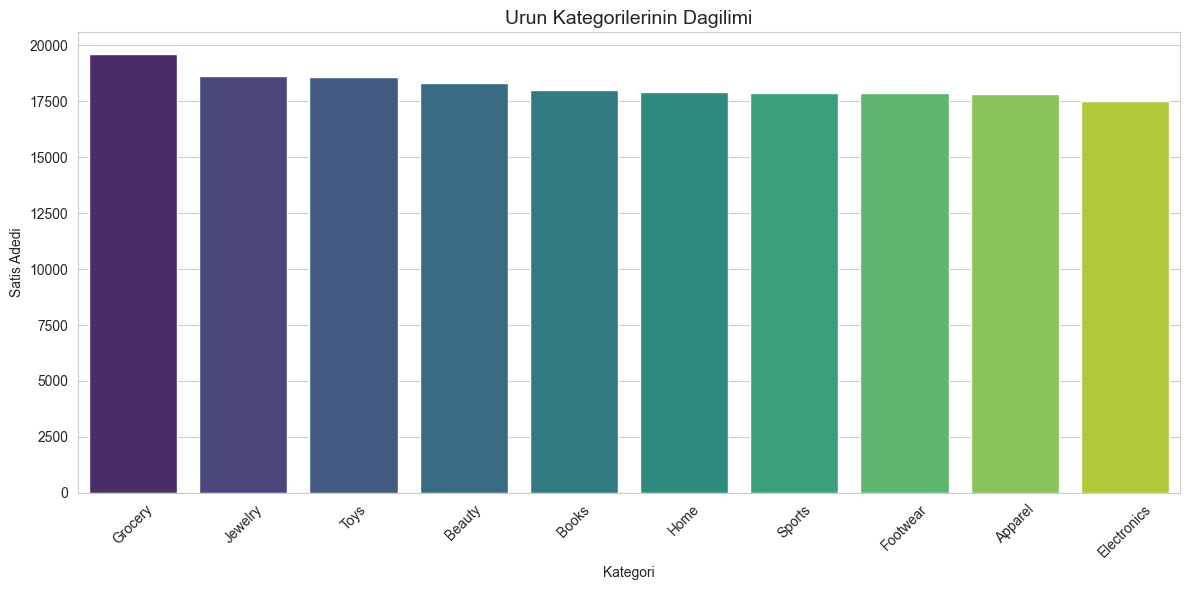

In [17]:
# Urun kategorilerinin dagilimi
plt.figure(figsize=(12, 6))
kategori_sayilari = df['Category'].value_counts()
sns.barplot(x=kategori_sayilari.index, y=kategori_sayilari.values, palette='viridis')
plt.title('Urun Kategorilerinin Dagilimi', fontsize=14)
plt.xlabel('Kategori')
plt.ylabel('Satis Adedi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

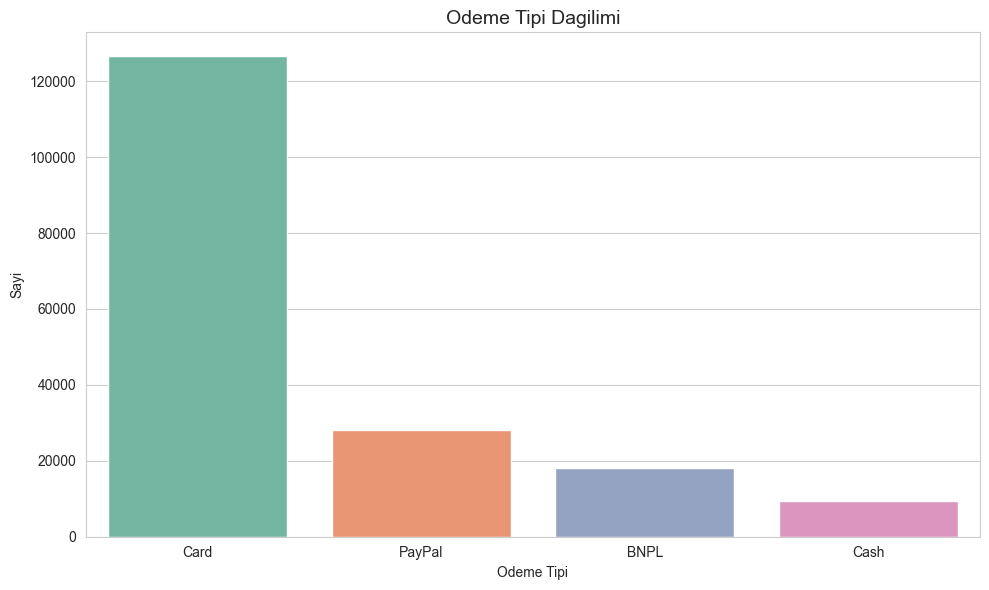

In [18]:
# Odeme tipi dagilimi - countplot kullanimi
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='PaymentType', palette='Set2')
plt.title('Odeme Tipi Dagilimi', fontsize=14)
plt.xlabel('Odeme Tipi')
plt.ylabel('Sayi')
plt.tight_layout()
plt.show()

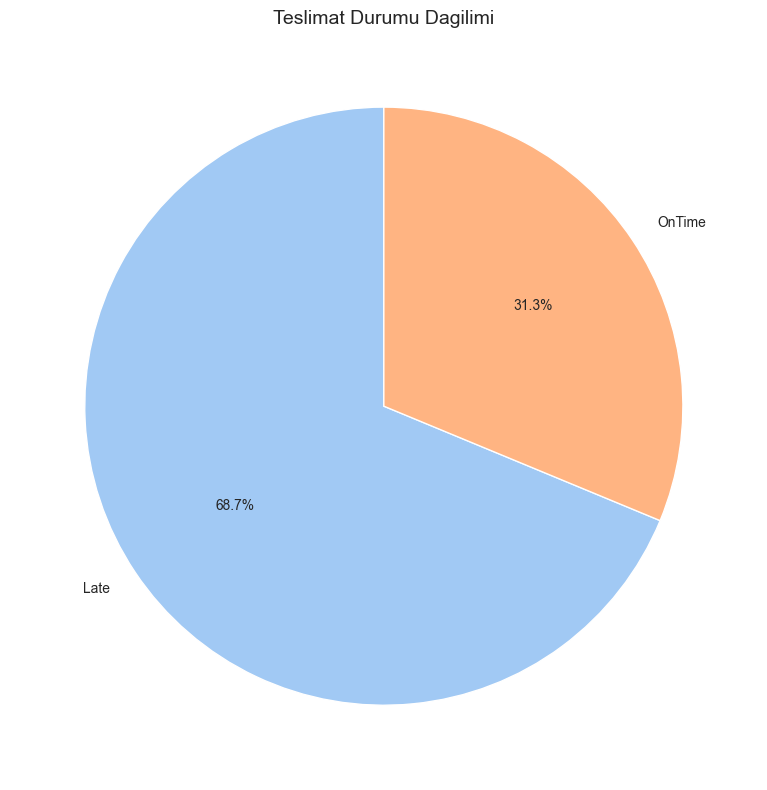

In [19]:
# Teslimat durumu dagilimi - pie chart
plt.figure(figsize=(10, 8))
teslimat_durumu = df['DeliveryStatus'].value_counts()
plt.pie(teslimat_durumu.values, labels=teslimat_durumu.index, autopct='%1.1f%%', 
        colors=sns.color_palette('pastel'), startangle=90)
plt.title('Teslimat Durumu Dagilimi', fontsize=14)
plt.tight_layout()
plt.show()

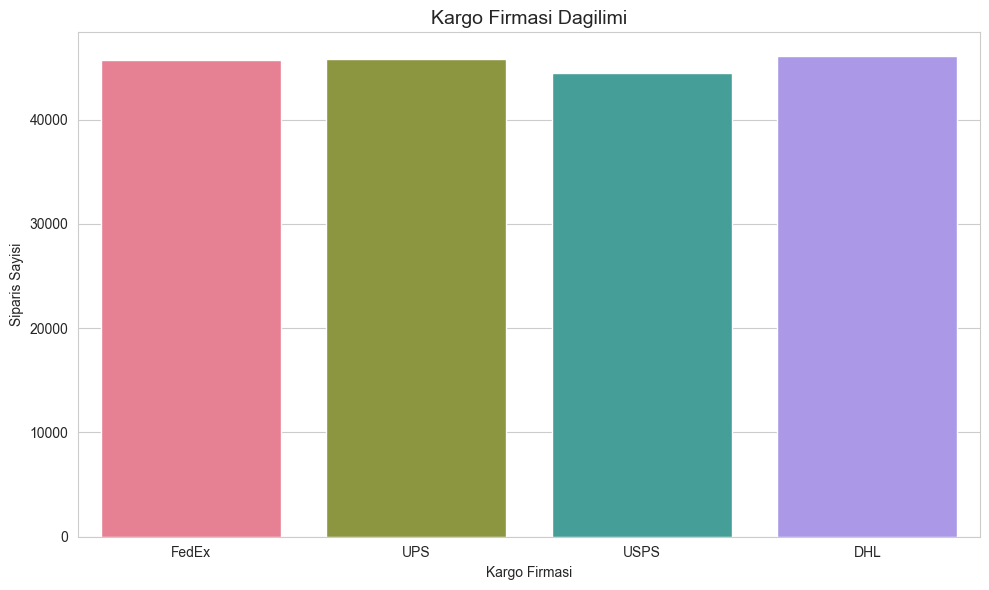

In [20]:
# Kargo firmasi dagilimi
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Carrier', palette='husl')
plt.title('Kargo Firmasi Dagilimi', fontsize=14)
plt.xlabel('Kargo Firmasi')
plt.ylabel('Siparis Sayisi')
plt.tight_layout()
plt.show()

### 5.2 Sayisal Degisken Gorsellestirmeleri

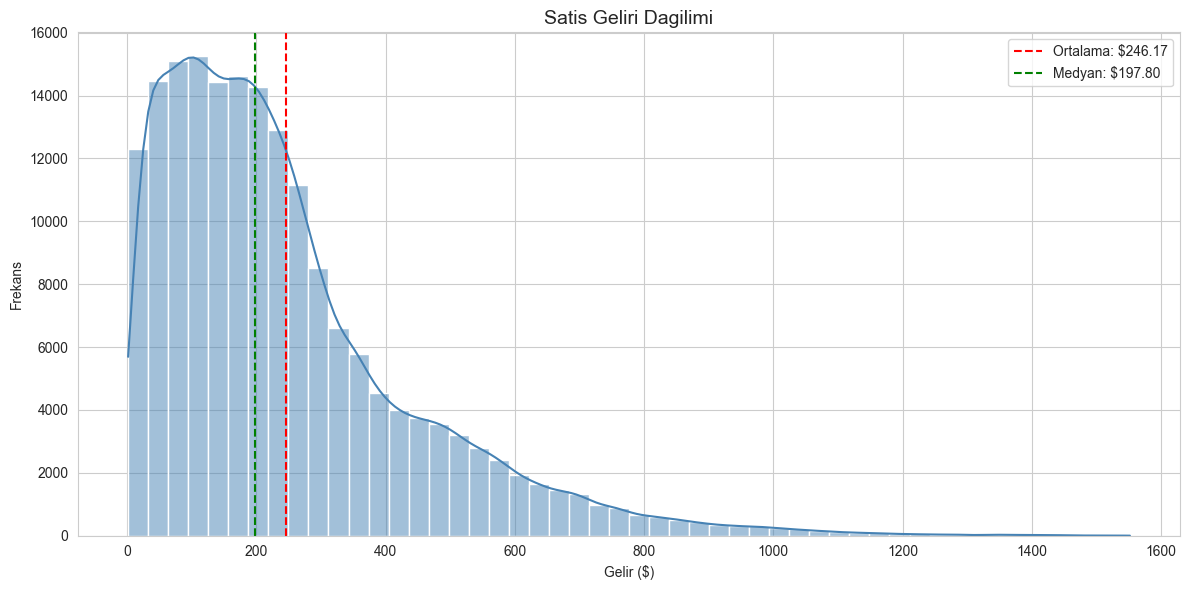

In [21]:
# Satis geliri dagilimi - histogram
plt.figure(figsize=(12, 6))
sns.histplot(df['LineRevenue$'], kde=True, bins=50, color='steelblue')
plt.title('Satis Geliri Dagilimi', fontsize=14)
plt.xlabel('Gelir ($)')
plt.ylabel('Frekans')

# Ortalama ve medyan cizgileri
plt.axvline(df['LineRevenue$'].mean(), color='red', linestyle='--', label=f'Ortalama: ${df["LineRevenue$"].mean():,.2f}')
plt.axvline(df['LineRevenue$'].median(), color='green', linestyle='--', label=f'Medyan: ${df["LineRevenue$"].median():,.2f}')
plt.legend()
plt.tight_layout()
plt.show()

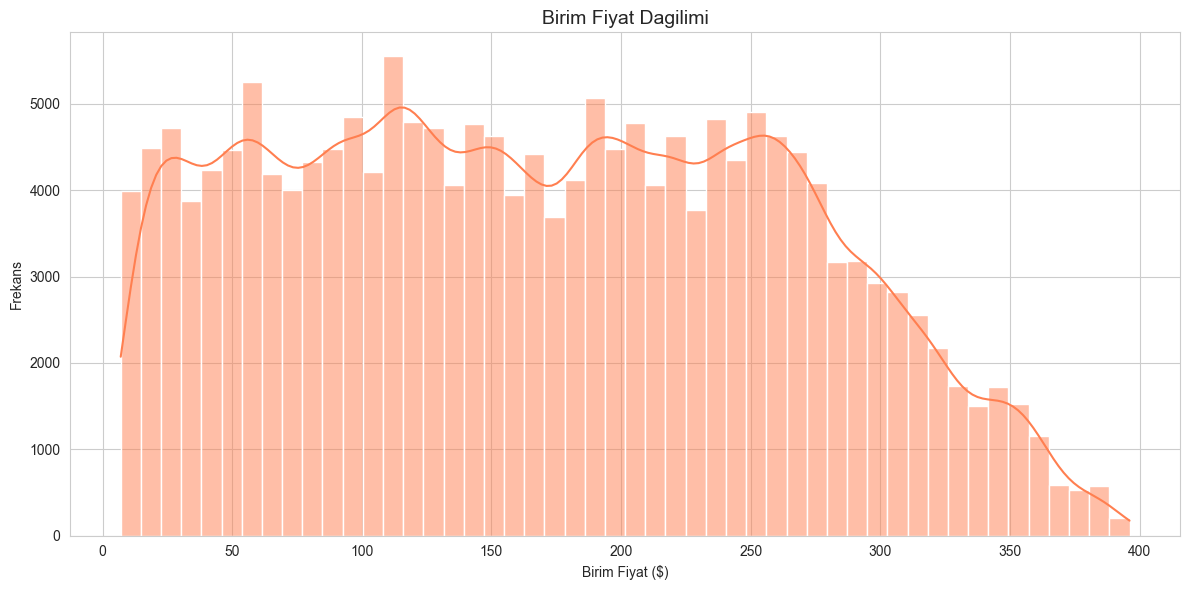

In [22]:
# Birim fiyat dagilimi
plt.figure(figsize=(12, 6))
sns.histplot(df['UnitPrice'], kde=True, bins=50, color='coral')
plt.title('Birim Fiyat Dagilimi', fontsize=14)
plt.xlabel('Birim Fiyat ($)')
plt.ylabel('Frekans')
plt.tight_layout()
plt.show()

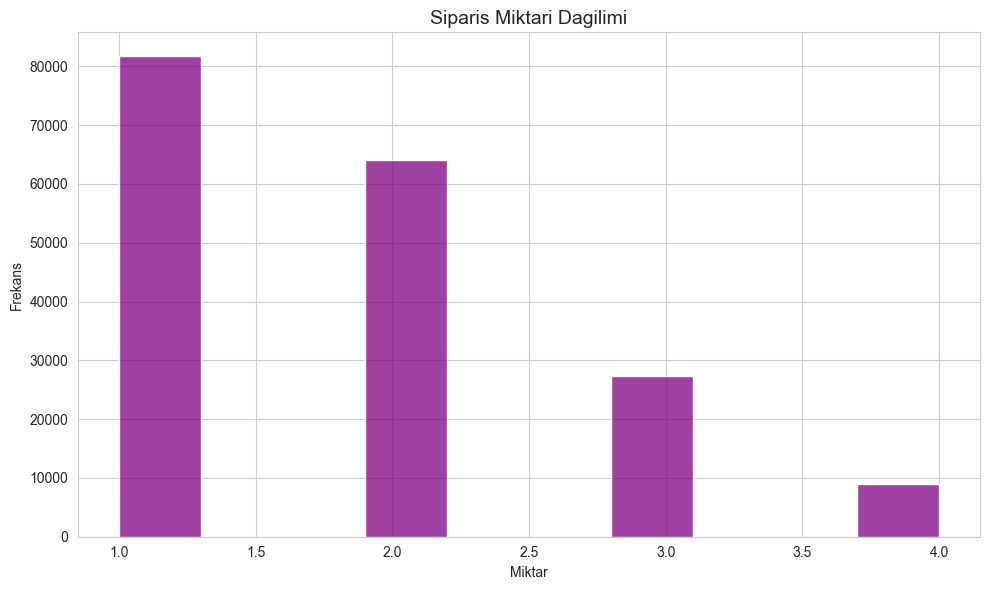

In [23]:
# Miktar dagilimi
plt.figure(figsize=(10, 6))
sns.histplot(df['Qty'], kde=False, bins=10, color='purple')
plt.title('Siparis Miktari Dagilimi', fontsize=14)
plt.xlabel('Miktar')
plt.ylabel('Frekans')
plt.tight_layout()
plt.show()

### 5.3 Boxplot Gorsellestirmeleri

Boxplot (kutu grafigi), verilerin dagilimini ve aykiri degerleri gormek icin kullanilir.

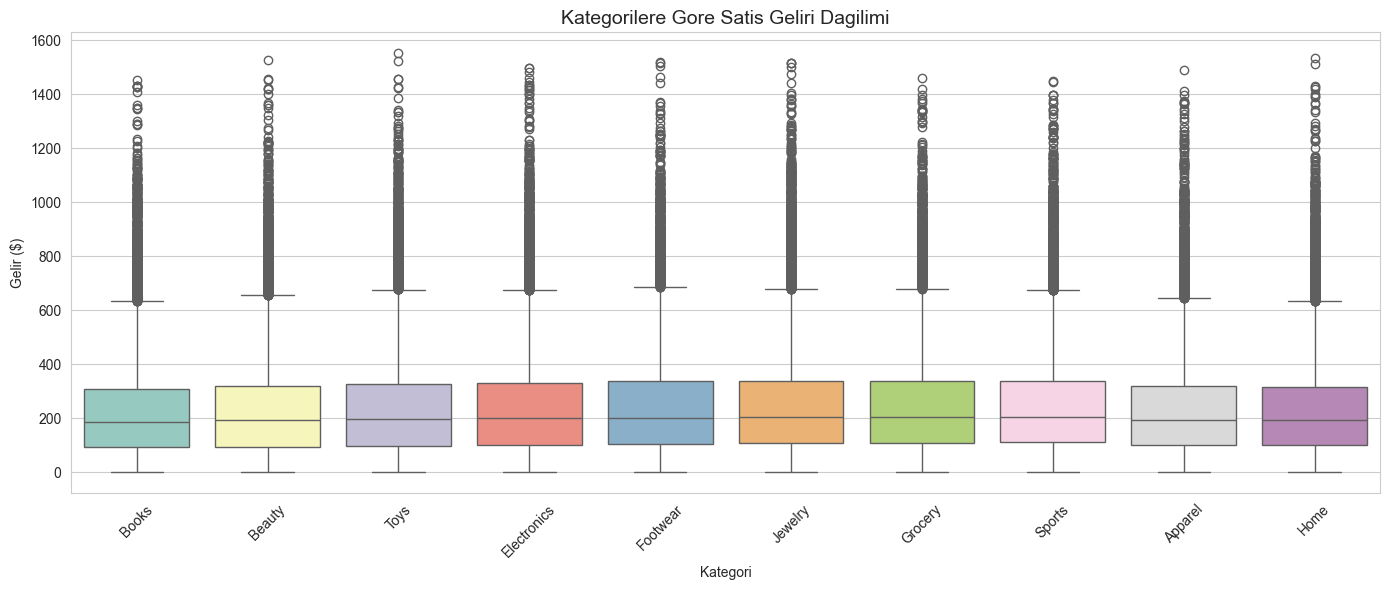

In [24]:
# Kategorilere gore gelir boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='Category', y='LineRevenue$', palette='Set3')
plt.title('Kategorilere Gore Satis Geliri Dagilimi', fontsize=14)
plt.xlabel('Kategori')
plt.ylabel('Gelir ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

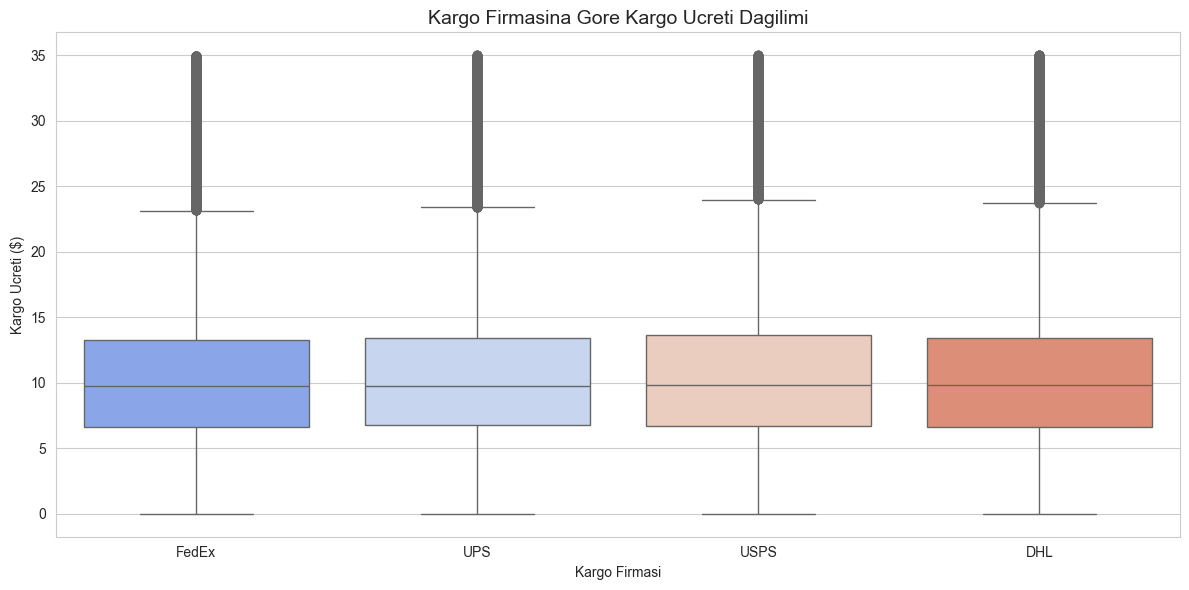

In [25]:
# Kargo firmasina gore kargo ucreti boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Carrier', y='ShipCost$', palette='coolwarm')
plt.title('Kargo Firmasina Gore Kargo Ucreti Dagilimi', fontsize=14)
plt.xlabel('Kargo Firmasi')
plt.ylabel('Kargo Ucreti ($)')
plt.tight_layout()
plt.show()

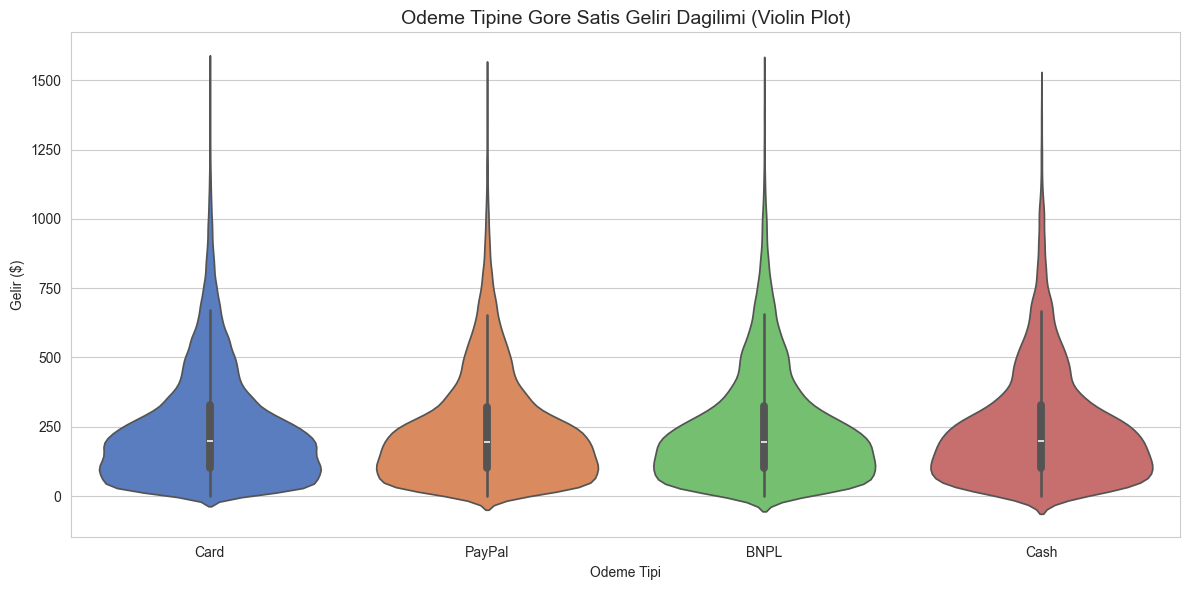

In [26]:
# Odeme tipine gore gelir violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='PaymentType', y='LineRevenue$', palette='muted')
plt.title('Odeme Tipine Gore Satis Geliri Dagilimi (Violin Plot)', fontsize=14)
plt.xlabel('Odeme Tipi')
plt.ylabel('Gelir ($)')
plt.tight_layout()
plt.show()

### 5.4 Korelasyon Analizi ve Heatmap

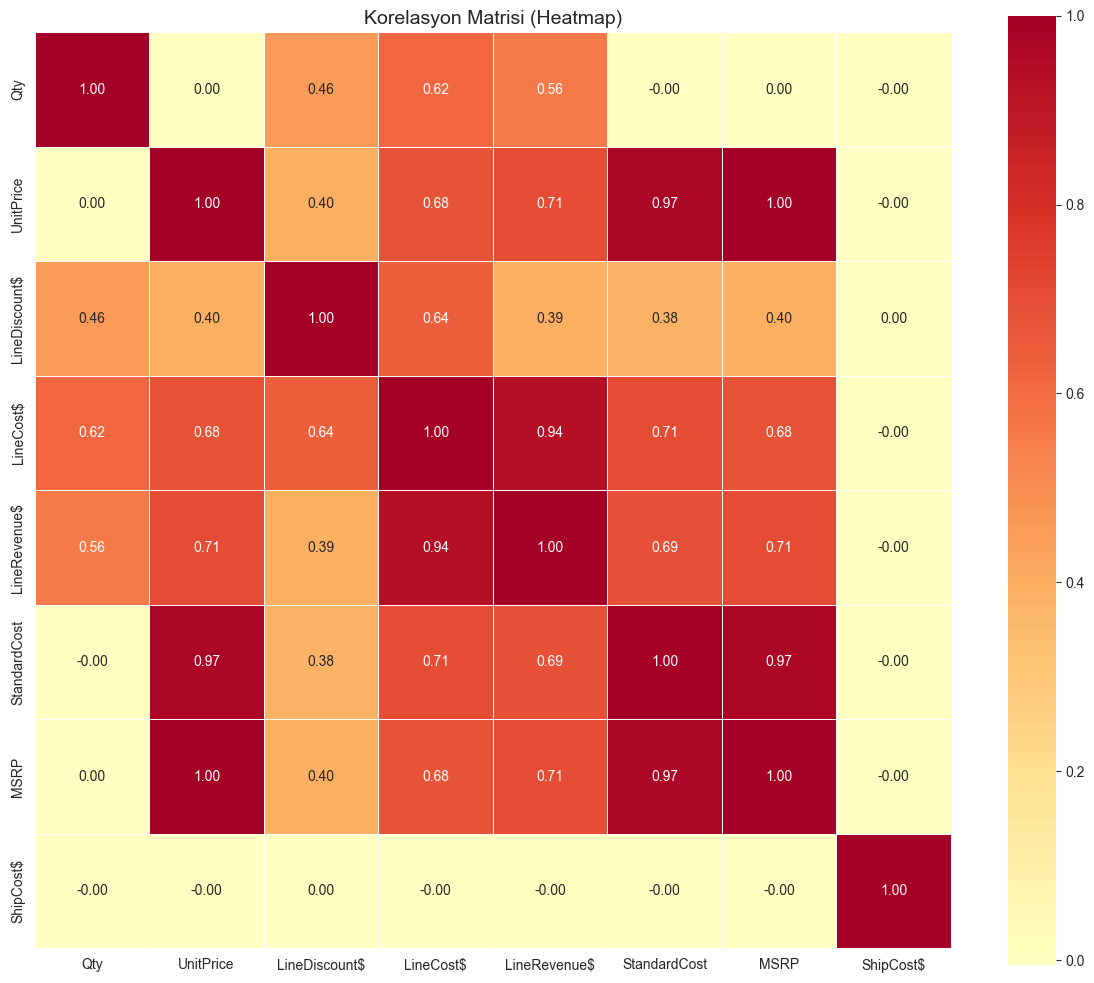

In [27]:
# Sayisal degiskenler arasindaki korelasyon
sayisal_sutunlar = ['Qty', 'UnitPrice', 'LineDiscount$', 'LineCost$', 'LineRevenue$', 
                    'StandardCost', 'MSRP', 'ShipCost$']

korelasyon = df[sayisal_sutunlar].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(korelasyon, annot=True, cmap='RdYlBu_r', center=0, fmt='.2f',
            square=True, linewidths=0.5)
plt.title('Korelasyon Matrisi (Heatmap)', fontsize=14)
plt.tight_layout()
plt.show()

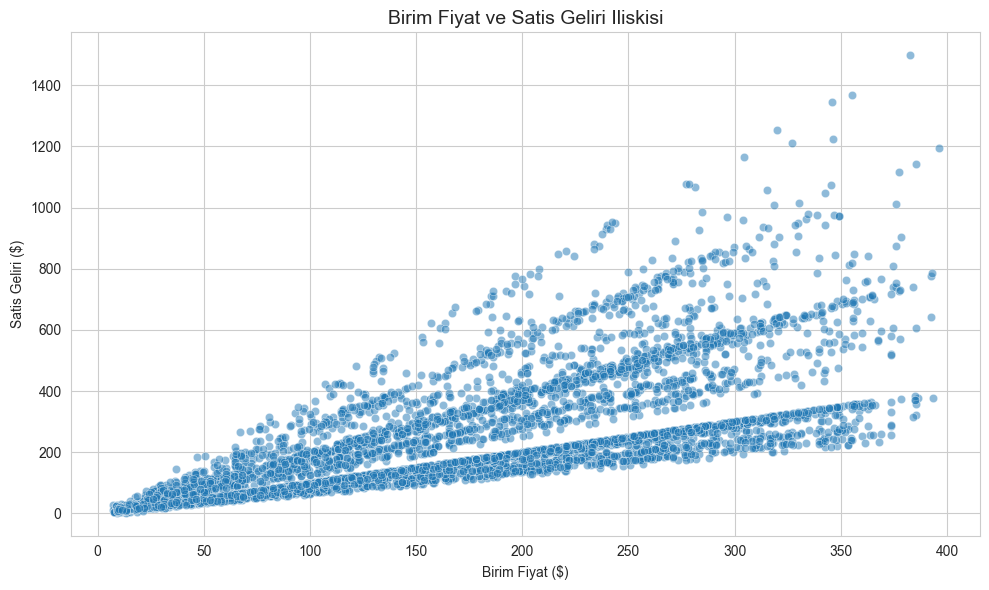

In [28]:
# Scatter plot - Birim fiyat ve Gelir iliskisi
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.sample(5000), x='UnitPrice', y='LineRevenue$', alpha=0.5)
plt.title('Birim Fiyat ve Satis Geliri Iliskisi', fontsize=14)
plt.xlabel('Birim Fiyat ($)')
plt.ylabel('Satis Geliri ($)')
plt.tight_layout()
plt.show()

### 5.5 Gruplandirma ve Aggregation Gorsellestirmeleri

In [29]:
# Kategorilere gore toplam gelir - groupby ve agg kullanimi
kategori_gelir = df.groupby('Category')['LineRevenue$'].agg(['sum', 'mean', 'count']).reset_index()
kategori_gelir.columns = ['Kategori', 'Toplam Gelir', 'Ortalama Gelir', 'Satis Adedi']
kategori_gelir = kategori_gelir.sort_values('Toplam Gelir', ascending=False)

print("KATEGORILERE GORE GELIR ANALIZI")
print("=" * 60)
kategori_gelir

KATEGORILERE GORE GELIR ANALIZI


,Kategori,Toplam Gelir,Ortalama Gelir,Satis Adedi
5,Grocery,4898149.25,249.841839,19605
7,Jewelry,4754395.83,255.064154,18640
9,Toys,4554430.44,245.138621,18579
8,Sports,4523718.05,253.174281,17868
4,Footwear,4504075.00,252.244344,17856
1,Beauty,4380488.19,239.018289,18327
3,Electronics,4368566.38,249.603838,17502
0,Apparel,4327071.42,242.698492,17829
6,Home,4306133.89,240.083290,17936
2,Books,4220740.85,234.537722,17996


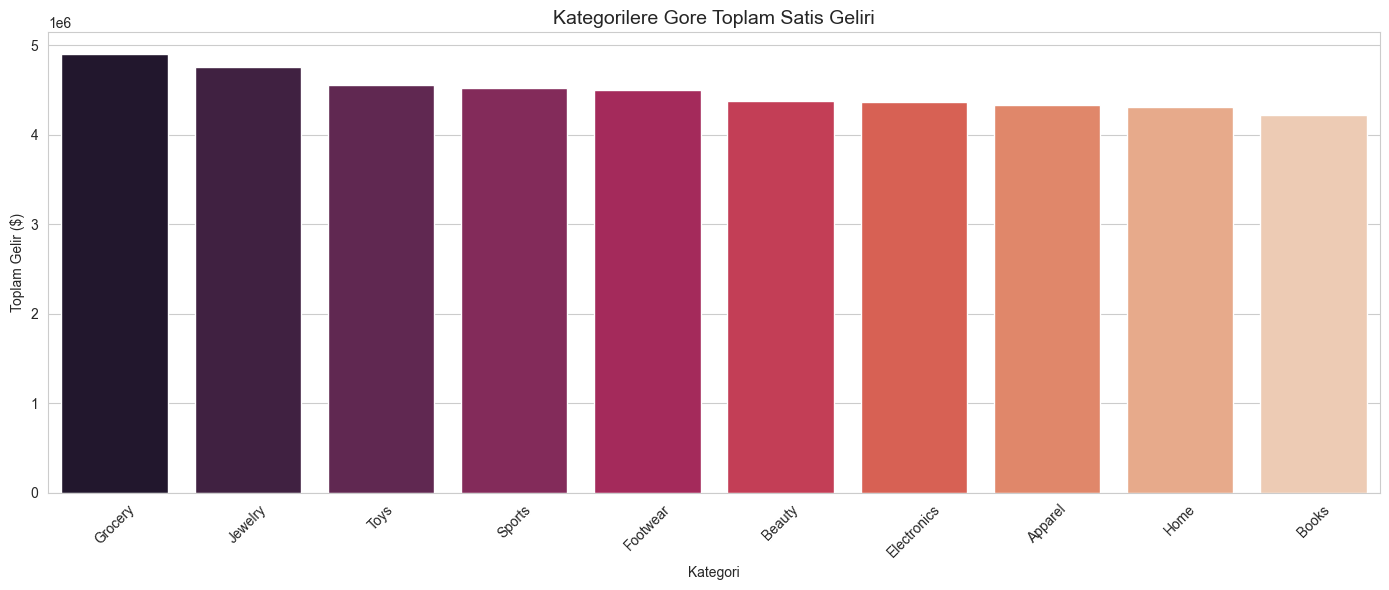

In [30]:
# Kategori bazli toplam gelir grafigi
plt.figure(figsize=(14, 6))
sns.barplot(data=kategori_gelir, x='Kategori', y='Toplam Gelir', palette='rocket')
plt.title('Kategorilere Gore Toplam Satis Geliri', fontsize=14)
plt.xlabel('Kategori')
plt.ylabel('Toplam Gelir ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
# Kargo firmasi ve teslimat durumu capraz tablosu - pivot table
pivot_tablo = pd.pivot_table(df, 
                             values='OrderID', 
                             index='Carrier', 
                             columns='DeliveryStatus', 
                             aggfunc='count',
                             fill_value=0)

print("KARGO FIRMASI ve TESLIMAT DURUMU (PIVOT TABLE)")
print("=" * 60)
pivot_tablo

KARGO FIRMASI ve TESLIMAT DURUMU (PIVOT TABLE)


DeliveryStatus,Late,OnTime
Carrier,,
DHL,31822,14254
FedEx,31458,14297
UPS,31665,14117
USPS,30274,14251


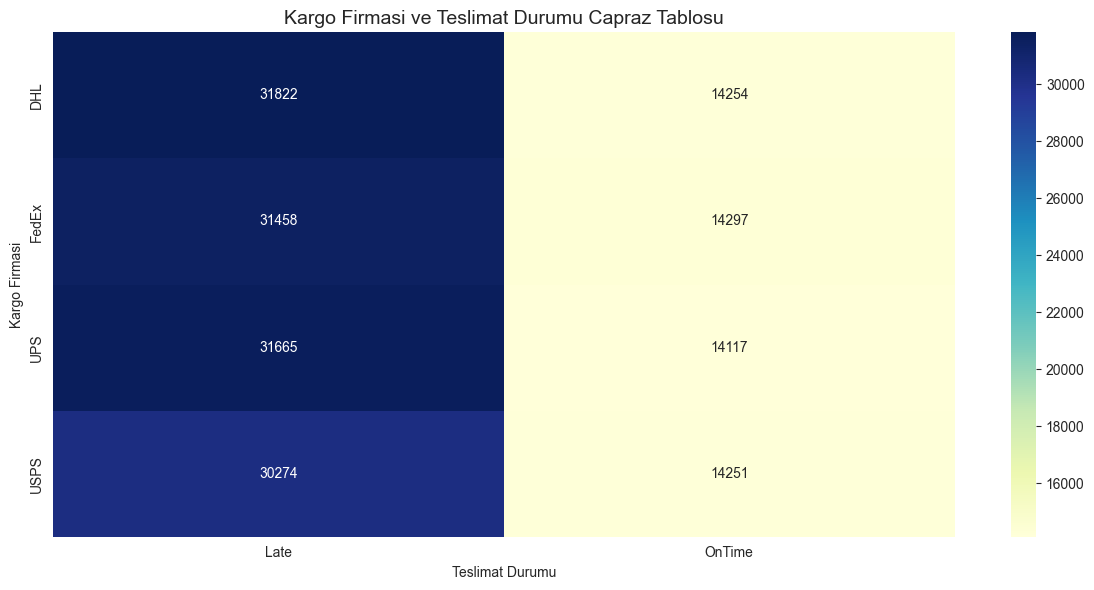

In [32]:
# Pivot table heatmap gorsellestirmesi
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_tablo, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Kargo Firmasi ve Teslimat Durumu Capraz Tablosu', fontsize=14)
plt.xlabel('Teslimat Durumu')
plt.ylabel('Kargo Firmasi')
plt.tight_layout()
plt.show()

## 6. Istatistiksel Testler

Hipotez testleri yaparak verilerimiz hakkinda istatistiksel cikarimlar yapacagiz.

### 6.1 Normallik Testi (Shapiro-Wilk)

Verilerin normal dagilip dagilmadigini test ediyoruz.

**Hipotezler:**
- H0: Veriler normal dagilima sahiptir
- H1: Veriler normal dagilima sahip degildir

In [33]:
# Shapiro-Wilk testi (kucuk orneklem icin)
# Buyuk veri setlerinde orneklem aliyoruz
orneklem = df['LineRevenue$'].sample(1000, random_state=42)

stat, p_value = shapiro(orneklem)

print("SHAPIRO-WILK NORMALLIK TESTI")
print("=" * 50)
print(f"Test Istatistigi: {stat:.4f}")
print(f"P-degeri: {p_value:.4f}")
print()

alpha = 0.05
if p_value > alpha:
    print(f"P-degeri ({p_value:.4f}) > alpha ({alpha})")
    print("Sonuc: H0 reddedilemez. Veriler normal dagilima sahip olabilir.")
else:
    print(f"P-degeri ({p_value:.4f}) < alpha ({alpha})")
    print("Sonuc: H0 reddedilir. Veriler normal dagilima sahip degildir.")

SHAPIRO-WILK NORMALLIK TESTI
Test Istatistigi: 0.8929
P-degeri: 0.0000

P-degeri (0.0000) < alpha (0.05)
Sonuc: H0 reddedilir. Veriler normal dagilima sahip degildir.


### 6.2 Iki Grup Karsilastirmasi (T-Testi)

Iki grubun ortalamalari arasinda anlamli fark olup olmadigini test ediyoruz.

In [34]:
# Credit Card ve Debit Card odeme tiplerine gore gelir karsilastirmasi
credit_card_gelir = df[df['PaymentType'] == 'Credit Card']['LineRevenue$']
debit_card_gelir = df[df['PaymentType'] == 'Debit Card']['LineRevenue$']

stat, p_value = ttest_ind(credit_card_gelir.sample(1000, random_state=42), 
                          debit_card_gelir.sample(1000, random_state=42))

print("BAGIMSIZ ORNEKLEM T-TESTI")
print("Credit Card vs Debit Card Gelir Karsilastirmasi")
print("=" * 50)
print(f"Credit Card Ortalama Gelir: ${credit_card_gelir.mean():,.2f}")
print(f"Debit Card Ortalama Gelir: ${debit_card_gelir.mean():,.2f}")
print(f"\nT-istatistigi: {stat:.4f}")
print(f"P-degeri: {p_value:.4f}")
print()

alpha = 0.05
if p_value > alpha:
    print(f"Sonuc: Iki grup arasinda istatistiksel olarak anlamli fark yoktur (p > {alpha}).")
else:
    print(f"Sonuc: Iki grup arasinda istatistiksel olarak anlamli fark vardir (p < {alpha}).")

ValueError: a must be greater than 0 unless no samples are taken

### 6.3 Coklu Grup Karsilastirmasi (ANOVA)

Ikiden fazla grubun ortalamalari arasinda anlamli fark olup olmadigini test ediyoruz.

In [ ]:
# Kargo firmalarina gore kargo ucreti karsilastirmasi (ANOVA)
kargo_firmalari = df['Carrier'].unique()
gruplar = [df[df['Carrier'] == kargo]['ShipCost$'].dropna() for kargo in kargo_firmalari]

stat, p_value = f_oneway(*gruplar)

print("TEK YONLU ANOVA TESTI")
print("Kargo Firmalarina Gore Kargo Ucreti Karsilastirmasi")
print("=" * 50)

for kargo in kargo_firmalari:
    ort = df[df['Carrier'] == kargo]['ShipCost$'].mean()
    print(f"{kargo} Ortalama Kargo Ucreti: ${ort:.2f}")

print(f"\nF-istatistigi: {stat:.4f}")
print(f"P-degeri: {p_value:.4f}")
print()

alpha = 0.05
if p_value > alpha:
    print(f"Sonuc: Gruplar arasinda istatistiksel olarak anlamli fark yoktur (p > {alpha}).")
else:
    print(f"Sonuc: En az iki grup arasinda istatistiksel olarak anlamli fark vardir (p < {alpha}).")

### 6.4 Korelasyon Testi (Pearson)

Iki sayisal degisken arasindaki dogrusal iliskinin gucunu ve yonunu test ediyoruz.

In [ ]:
# UnitPrice ve LineRevenue$ arasindaki korelasyon
korelasyon_katsayisi, p_value = pearsonr(df['UnitPrice'], df['LineRevenue$'])

print("PEARSON KORELASYON TESTI")
print("Birim Fiyat ve Satis Geliri Iliskisi")
print("=" * 50)
print(f"Korelasyon Katsayisi (r): {korelasyon_katsayisi:.4f}")
print(f"P-degeri: {p_value:.4e}")
print()

# Korelasyon yorumu
if abs(korelasyon_katsayisi) >= 0.7:
    guc = "guclu"
elif abs(korelasyon_katsayisi) >= 0.4:
    guc = "orta duzeyde"
else:
    guc = "zayif"

yon = "pozitif" if korelasyon_katsayisi > 0 else "negatif"

print(f"Yorum: Iki degisken arasinda {guc} {yon} iliski vardir.")

## 7. Veri On Isleme

Makine ogrenmesi modelleri icin veriyi hazirliyoruz.

### 7.1 Hedef Degisken Olusturma

Teslimat durumunu tahmin eden bir siniflandirma modeli kuracagiz. Bunun icin hedef degiskenimizi belirliyoruz.

In [ ]:
# Teslimat durumu dagilimini inceleyelim
print("TESLIMAT DURUMU DAGILIMI")
print("=" * 50)
print(df['DeliveryStatus'].value_counts())
print()
print(df['DeliveryStatus'].value_counts(normalize=True).round(4) * 100)

In [ ]:
# Hedef degisken: Teslimatin zamaninda yapilip yapilmadigi
# 'Delivered' -> 1 (Basarili), digerleri -> 0 (Basarisiz)
df['Basarili_Teslimat'] = (df['DeliveryStatus'] == 'Delivered').astype(int)

print("HEDEF DEGISKEN DAGILIMI")
print("=" * 50)
print(df['Basarili_Teslimat'].value_counts())
print()
print(f"Basarili Teslimat Orani: %{df['Basarili_Teslimat'].mean() * 100:.2f}")

### 7.2 Ozellik Secimi ve Veri Hazirlama

In [ ]:
# Model icin kullanilacak ozellikleri seciyoruz
# Kategorik degiskenler: Category, PaymentType, Carrier, ServiceLevel
# Sayisal degiskenler: Qty, UnitPrice, LineRevenue$, ShipCost$

# Sadece gerekli sutunlari seciyoruz ve eksik verileri temizliyoruz
model_df = df[['Category', 'PaymentType', 'Carrier', 'ServiceLevel',
               'Qty', 'UnitPrice', 'LineRevenue$', 'ShipCost$', 'Basarili_Teslimat']].copy()

# Eksik verileri kontrol edelim
print("EKSIK VERI KONTROLU")
print("=" * 50)
print(model_df.isnull().sum())

In [ ]:
# Eksik verileri temizliyoruz
model_df = model_df.dropna()
print(f"Temizlenen veri seti boyutu: {model_df.shape}")

### 7.3 Label Encoding

Kategorik degiskenleri sayisal degerlere donusturuyoruz.

In [ ]:
# Label Encoder nesnesi olusturuyoruz
le = LabelEncoder()

# Kategorik sutunlari donusturuyoruz
kategorik_sutunlar = ['Category', 'PaymentType', 'Carrier', 'ServiceLevel']

for sutun in kategorik_sutunlar:
    model_df[sutun + '_encoded'] = le.fit_transform(model_df[sutun])
    print(f"{sutun} donusturuldu.")
    print(f"Benzersiz degerler: {model_df[sutun].nunique()}")
    print()

In [ ]:
# Donusturulmus veri setini inceleyelim
model_df.head()

### 7.4 Ozellik ve Hedef Degiskenlerin Ayrilmasi

In [ ]:
# Bagimsiz degiskenler (X) ve bagimli degisken (y)
ozellik_sutunlari = ['Qty', 'UnitPrice', 'LineRevenue$', 'ShipCost$',
                     'Category_encoded', 'PaymentType_encoded', 
                     'Carrier_encoded', 'ServiceLevel_encoded']

X = model_df[ozellik_sutunlari]
y = model_df['Basarili_Teslimat']

print("OZELLIK MATRISI (X)")
print(f"Boyut: {X.shape}")
print(f"Sutunlar: {X.columns.tolist()}")
print()
print("HEDEF DEGISKEN (y)")
print(f"Boyut: {y.shape}")

### 7.5 Egitim ve Test Setlerine Ayirma

In [ ]:
# Veriyi %80 egitim, %20 test olarak ayiriyoruz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("VERI SETI BOLUNMESI")
print("=" * 50)
print(f"Egitim seti boyutu: {X_train.shape[0]} satir")
print(f"Test seti boyutu: {X_test.shape[0]} satir")
print(f"\nEgitim seti orani: %{len(X_train) / len(X) * 100:.0f}")
print(f"Test seti orani: %{len(X_test) / len(X) * 100:.0f}")

### 7.6 Olceklendirme (Scaling)

Farkli olceklerdeki degiskenleri standardlastiriyoruz.

In [ ]:
# StandardScaler ile olceklendirme
scaler = StandardScaler()

# Egitim seti uzerinde fit ve transform
X_train_scaled = scaler.fit_transform(X_train)

# Test seti uzerinde sadece transform (fit yok - veri sizintisini onlemek icin)
X_test_scaled = scaler.transform(X_test)

print("OLCEKLENDIRME TAMAMLANDI")
print("=" * 50)
print(f"Olceklendirme oncesi - Egitim seti ortalamasi: {X_train.mean().mean():.4f}")
print(f"Olceklendirme sonrasi - Egitim seti ortalamasi: {X_train_scaled.mean():.4f}")

## 8. Makine Ogrenmesi Modelleri

Farkli siniflandirma algoritmalari kullanarak modeller olusturacagiz.

### 8.1 Lojistik Regresyon

Lojistik regresyon, ikili siniflandirma problemleri icin kullanilan temel bir algoritmadir.

In [ ]:
# Lojistik Regresyon modeli
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Tahmin
y_pred_log = log_reg.predict(X_test_scaled)

print("LOJISTIK REGRESYON SONUCLARI")
print("=" * 50)
print(f"Egitim Dogrulugu: %{log_reg.score(X_train_scaled, y_train) * 100:.2f}")
print(f"Test Dogrulugu: %{accuracy_score(y_test, y_pred_log) * 100:.2f}")

In [ ]:
# Karisiklik Matrisi (Confusion Matrix)
cm_log = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Basarisiz', 'Basarili'],
            yticklabels=['Basarisiz', 'Basarili'])
plt.title('Lojistik Regresyon - Karisiklik Matrisi', fontsize=14)
plt.xlabel('Tahmin')
plt.ylabel('Gercek')
plt.tight_layout()
plt.show()

In [ ]:
# Siniflandirma Raporu
print("SINIFLANDIRMA RAPORU")
print("=" * 50)
print(classification_report(y_test, y_pred_log, target_names=['Basarisiz', 'Basarili']))

### 8.2 Karar Agaci (Decision Tree)

Karar agaclari, verileri karar kurallarina gore bolen yorumlanabilir bir algoritmadir.

In [ ]:
# Karar Agaci modeli
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_model.fit(X_train_scaled, y_train)

# Tahmin
y_pred_dt = dt_model.predict(X_test_scaled)

print("KARAR AGACI SONUCLARI")
print("=" * 50)
print(f"Egitim Dogrulugu: %{dt_model.score(X_train_scaled, y_train) * 100:.2f}")
print(f"Test Dogrulugu: %{accuracy_score(y_test, y_pred_dt) * 100:.2f}")

In [ ]:
# Karar Agaci - Karisiklik Matrisi
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Basarisiz', 'Basarili'],
            yticklabels=['Basarisiz', 'Basarili'])
plt.title('Karar Agaci - Karisiklik Matrisi', fontsize=14)
plt.xlabel('Tahmin')
plt.ylabel('Gercek')
plt.tight_layout()
plt.show()

In [ ]:
# Ozellik Onem Dereceleri
ozellik_onemleri = pd.DataFrame({
    'Ozellik': ozellik_sutunlari,
    'Onem': dt_model.feature_importances_
}).sort_values('Onem', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=ozellik_onemleri, x='Onem', y='Ozellik', palette='viridis')
plt.title('Karar Agaci - Ozellik Onem Dereceleri', fontsize=14)
plt.xlabel('Onem Derecesi')
plt.ylabel('Ozellik')
plt.tight_layout()
plt.show()

### 8.3 Random Forest (Rastgele Orman)

Random Forest, birden fazla karar agacini birlestiren guclu bir topluluk (ensemble) yontemidir.

In [ ]:
# Random Forest modeli
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_scaled, y_train)

# Tahmin
y_pred_rf = rf_model.predict(X_test_scaled)

print("RANDOM FOREST SONUCLARI")
print("=" * 50)
print(f"Egitim Dogrulugu: %{rf_model.score(X_train_scaled, y_train) * 100:.2f}")
print(f"Test Dogrulugu: %{accuracy_score(y_test, y_pred_rf) * 100:.2f}")

In [ ]:
# Random Forest - Karisiklik Matrisi
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Basarisiz', 'Basarili'],
            yticklabels=['Basarisiz', 'Basarili'])
plt.title('Random Forest - Karisiklik Matrisi', fontsize=14)
plt.xlabel('Tahmin')
plt.ylabel('Gercek')
plt.tight_layout()
plt.show()

In [ ]:
# Random Forest - Ozellik Onem Dereceleri
rf_ozellik_onemleri = pd.DataFrame({
    'Ozellik': ozellik_sutunlari,
    'Onem': rf_model.feature_importances_
}).sort_values('Onem', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=rf_ozellik_onemleri, x='Onem', y='Ozellik', palette='rocket')
plt.title('Random Forest - Ozellik Onem Dereceleri', fontsize=14)
plt.xlabel('Onem Derecesi')
plt.ylabel('Ozellik')
plt.tight_layout()
plt.show()

### 8.4 K-En Yakin Komsu (KNN)

KNN, bir veri noktasini en yakin k komsusuna gore siniflandiran basit bir algoritmadir.

In [ ]:
# KNN modeli
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# Tahmin
y_pred_knn = knn_model.predict(X_test_scaled)

print("K-EN YAKIN KOMSU (KNN) SONUCLARI")
print("=" * 50)
print(f"Egitim Dogrulugu: %{knn_model.score(X_train_scaled, y_train) * 100:.2f}")
print(f"Test Dogrulugu: %{accuracy_score(y_test, y_pred_knn) * 100:.2f}")

In [ ]:
# KNN - Karisiklik Matrisi
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Basarisiz', 'Basarili'],
            yticklabels=['Basarisiz', 'Basarili'])
plt.title('KNN - Karisiklik Matrisi', fontsize=14)
plt.xlabel('Tahmin')
plt.ylabel('Gercek')
plt.tight_layout()
plt.show()

## 9. Model Karsilastirmasi ve Degerlendirme

In [ ]:
# Tum modellerin sonuclarini karsilastiralim
model_sonuclari = pd.DataFrame({
    'Model': ['Lojistik Regresyon', 'Karar Agaci', 'Random Forest', 'KNN'],
    'Egitim Dogrulugu': [
        log_reg.score(X_train_scaled, y_train) * 100,
        dt_model.score(X_train_scaled, y_train) * 100,
        rf_model.score(X_train_scaled, y_train) * 100,
        knn_model.score(X_train_scaled, y_train) * 100
    ],
    'Test Dogrulugu': [
        accuracy_score(y_test, y_pred_log) * 100,
        accuracy_score(y_test, y_pred_dt) * 100,
        accuracy_score(y_test, y_pred_rf) * 100,
        accuracy_score(y_test, y_pred_knn) * 100
    ]
}).round(2)

print("MODEL KARSILASTIRMASI")
print("=" * 60)
print(model_sonuclari.to_string(index=False))

In [ ]:
# Model karsilastirma grafigi
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(model_sonuclari))
width = 0.35

bars1 = ax.bar(x - width/2, model_sonuclari['Egitim Dogrulugu'], width, label='Egitim', color='steelblue')
bars2 = ax.bar(x + width/2, model_sonuclari['Test Dogrulugu'], width, label='Test', color='coral')

ax.set_xlabel('Model')
ax.set_ylabel('Dogruluk (%)')
ax.set_title('Model Performans Karsilastirmasi', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(model_sonuclari['Model'])
ax.legend()
ax.set_ylim(0, 100)

# Degerleri barlarin uzerine yazalim
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### 9.1 ROC Egrisi ve AUC

In [ ]:
# ROC egrisini cizelim
plt.figure(figsize=(10, 8))

# Her model icin ROC egrisi
modeller = {
    'Lojistik Regresyon': (log_reg, 'blue'),
    'Karar Agaci': (dt_model, 'green'),
    'Random Forest': (rf_model, 'red'),
    'KNN': (knn_model, 'purple')
}

for model_adi, (model, renk) in modeller.items():
    # Olasilik tahminleri
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # ROC egrisi degerleri
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    
    plt.plot(fpr, tpr, color=renk, label=f'{model_adi} (AUC = {auc:.3f})')

# Referans cizgisi (rastgele tahmin)
plt.plot([0, 1], [0, 1], 'k--', label='Rastgele Tahmin')

plt.xlabel('False Positive Rate (Yanlis Pozitif Orani)')
plt.ylabel('True Positive Rate (Dogru Pozitif Orani)')
plt.title('ROC Egrisi Karsilastirmasi', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 9.2 Capraz Dogrulama (Cross Validation)

In [ ]:
# 5-Katli Capraz Dogrulama
print("5-KATLI CAPRAZ DOGRULAMA SONUCLARI")
print("=" * 60)

cv_sonuclari = []

for model_adi, (model, _) in modeller.items():
    cv_skorlari = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_sonuclari.append({
        'Model': model_adi,
        'Ortalama': cv_skorlari.mean() * 100,
        'Std': cv_skorlari.std() * 100
    })
    print(f"{model_adi}:")
    print(f"  Skorlar: {[f'{s*100:.2f}%' for s in cv_skorlari]}")
    print(f"  Ortalama: %{cv_skorlari.mean() * 100:.2f} (+/- {cv_skorlari.std() * 100:.2f})")
    print()

cv_df = pd.DataFrame(cv_sonuclari)

In [ ]:
# Capraz dogrulama sonuclari grafigi
plt.figure(figsize=(10, 6))
plt.bar(cv_df['Model'], cv_df['Ortalama'], yerr=cv_df['Std'], capsize=5, color='teal', alpha=0.7)
plt.xlabel('Model')
plt.ylabel('Dogruluk (%)')
plt.title('5-Katli Capraz Dogrulama Sonuclari', fontsize=14)
plt.ylim(0, 100)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## 10. Sonuc ve Degerlendirme

In [ ]:
# En iyi modeli belirleyelim
en_iyi_model = model_sonuclari.loc[model_sonuclari['Test Dogrulugu'].idxmax()]

print("=" * 60)
print("PROJE SONUC RAPORU")
print("=" * 60)
print()
print("1. VERI SETI")
print(f"   - Toplam kayit sayisi: {len(df):,}")
print(f"   - Kullanilan ozellik sayisi: {len(ozellik_sutunlari)}")
print(f"   - Egitim seti: {len(X_train):,} kayit")
print(f"   - Test seti: {len(X_test):,} kayit")
print()
print("2. MODEL SONUCLARI")
for _, row in model_sonuclari.iterrows():
    print(f"   - {row['Model']}: Test Dogrulugu = %{row['Test Dogrulugu']:.2f}")
print()
print(f"3. EN IYI MODEL: {en_iyi_model['Model']}")
print(f"   - Test Dogrulugu: %{en_iyi_model['Test Dogrulugu']:.2f}")
print()
print("4. KULLANILAN TEKNIKLER")
print("   - Veri birlestirme (merge)")
print("   - Kesifsel veri analizi (EDA)")
print("   - Istatistiksel testler (Shapiro, T-test, ANOVA, Pearson)")
print("   - Gorsellestirmeler (Histogram, Boxplot, Heatmap, Scatter)")
print("   - Label Encoding")
print("   - StandardScaler")
print("   - Siniflandirma modelleri (Logistic, DT, RF, KNN)")
print("   - Capraz dogrulama (Cross Validation)")
print("   - ROC-AUC analizi")
print("=" * 60)

---

## Kaynaklar

- Python ile Veri Bilimi Ders Notlari
- Scikit-learn Dokumantasyonu: https://scikit-learn.org/
- Pandas Dokumantasyonu: https://pandas.pydata.org/
- Seaborn Dokumantasyonu: https://seaborn.pydata.org/

---